# Workshop 3: Deep Reinforcement Learning for Price Optimization

![](./images/scm_optimization.jpg)

Supply chain and price management were among the first areas of enterprise operations that adopted data science and combinatorial optimization methods and have a long history of using these techniques with great success.

Although a wide range of traditional optimization methods are available for
inventory and price management applications, deep reinforcement learning has the
potential to substantially improve the optimization capabilities.

* We start with a simple motivating example that illustrates how slight modifications of
traditional price optimization problems can result in complex behaviour and increase
optimization complexity.
* Next, we use this simplistic price management environment to develop and evaluate
our first optimizer using only a vanilla PyTorch toolkit.
* We then discuss how the implementation can be drastically simplified and made more
robust with RLlib, an open-source library for reinforcement learning.

## Introduction

**Differential price response and Hi-Lo pricing**

The traditional *price optimization* process in retail or manufacturing environments is typically framed as a *what-if analysis* of different pricing scenarios using some sort of demand model. In many cases, the development of a demand model is challenging because it has to properly capture a wide range of factors and variables that influence demand, including regular prices, discounts, marketing activities, seasonality, competitor prices, cross-product cannibalization, and halo effects. 

Once the demand model is developed, however, the optimization process for pricing decisions is relatively straightforward, and standard techniques such as linear or integer programming typically suffice. For instance, consider an apparel retailer that purchases a seasonal product at the beginning of the season and has to sell it out by the end of the period. Assuming that a retailer chooses pricing levels from a discrete set (e.g., \\$59.90, \\$69.90, etc.) and can make price changes frequently (e.g., weekly), we can pose the following optimization problem:

$$ max \sum_{t} \sum_{j} p_j \cdot d(t, j) \cdot x_{tj} $$
$$ subject\ to \sum_{j} x_{tj} = 1,\ for\ all\ t $$
$$ \sum_t \sum_j d(t, j) \cdot x_{t,j} = c $$
$$ x_{tj}\ \epsilon\ 0, 1 $$

where $t$ iterates over time intervals, $j$ is an index that iterates over the valid price levels,
$p_j$ is the price with index $j$, $d(t,j)$ is the demand at time $t$ given price level $j$, $c$ is the inventory level at the beginning of the season, and $x_{tj}$ is a binary dummy variable that is equal to one if price $j$ is assigned to time interval $t$, and zero otherwise. 

The first constraint ensures that each time interval has only one price, and the second constraint ensures that all demands sum up to the available stock level. This is an integer programming problem that can be solved using conventional optimization libraries.

The above model is quite flexible because it allows for a price-demand function of an arbitrary shape (linear, constant elasticity, etc.) and arbitrary seasonal patterns. It can also be straightforwardly extended to support joint price optimization for multiple products. The model, however, assumes no dependency between time intervals.

Let us now explore how the dependencies between time intervals can impact the optimization process. In the real world, demand depends not only on the absolute price level but can also be impacted by the magnitude of recent price changes—price decrease can create a temporary demand splash, while price increase can result in a temporary demand drop. The impact of price changes can also be asymmetric, so that price increases have a much bigger or smaller impact than the decreases. We can codify these assumptions using the following price-demand function:

$$ d(p_t, p_{t-1}) = d_0 - k \cdot p_t - a \cdot s((p_t - p_{t-1})^+) + b \cdot s ((p_t - p_{t-1})^-) $$

where 
$$ x^+ = x\ \texttt{if}\ x > 0,\ \texttt{and}\ 0\ \texttt{otherwise} $$
$$ x^- = x\ \texttt{if}\ x < 0,\ \texttt{and}\ 0\ \texttt{otherwise} $$

and $p_t$ is the price for the current time interval and $p_{t−1}$ is the price for the previous time interval. The first two terms correspond to a linear demand model with intercept $d_0$ and slope $k$. The second two terms model the response on a price change between two intervals. Coefficients $a$ and $b$ define the sensitivity to positive and negative price changes, respectively, and $s$ is a shock function that can be used to specify a non-linear dependency between the price change and demand. For the sake of illustration, we assume that $s(x) = \sqrt{x}$.

Let us now investigate what the optimal price schedule for such a price-response function looks like. We start by implementing functions that compute profit for a given price schedule (a vector of prices for several time steps):

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from matplotlib import animation, rc

In [2]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand (q) at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + \
            sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(1, len(p))))

## Environment parameters
T = 20
price_max = 500
price_step = 10
q_0 = 5000
k = 20
unit_cost = 100
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

We can visualize this environment by plotting profit functions that correspond to different magnitudes of price changes:

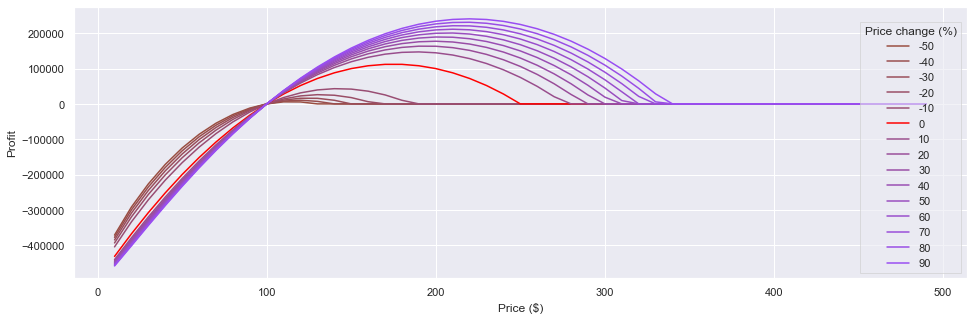

In [3]:
## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i] * price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'red'
    else:
        color = (0.6, 0.3, price_change_grid[i]/2.0)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((price_change_grid-1)*100)), loc='lower right', 
           title="Price change (%)", fancybox=False, framealpha=0.6)

We can see that price decreases "deflate" the baseline profit function, while price increases "inflate" it. Next, establish two baselines using basic optimization techniques:
* Optimal constant price
* Optimal price schedule using sequential greedy search (optimize prices one by one)

In [4]:
# Find optimal constant price

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 170, achieved profit is 2240000.0


The constant-price schedule is not optimal for this environment, and we can improve profits through greedy optimization: start with finding the optimal price for the first time step, then optimize the second time step having frozen the first one, and so on.

This approach improves profit significantly and produces the following price schedule:

[190 180 170 490 220 190 180 170 490 220 190 180 170 490 220 190 180 170
 490 210]
Achieved profit is 2745227.3180795736


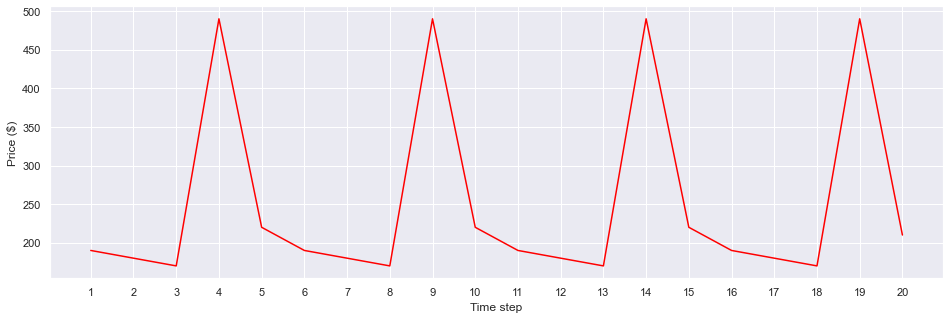

In [5]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    profit_grid = np.array([ profit_response(p) for p in p_grid ])
    return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_grid, t)
    p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(ticks=list(range(21)))
plt.plot(range(1,len(p_opt)+1), p_opt, c='red')

This result is remarkable: a simple temporal dependency inside the price-demand function dictates a complex pricing strategy with price surges and discounts. It can be viewed as a formal justification of the *Hi-Lo pricing strategy* used by many retailers; we see how altering regular and promotional prices helps to maximize profit.

The above example sheds light on the relationship between **price management** and **reinforcement learning**. The price-response function we have defined is essentially a differential equation where the profit depends not only on the current price action but also on the dynamics of the price. It is expected that such equations can exhibit very complicated behavior, especially over long-time intervals, so the corresponding control policies can also become complicated. Optimization of such policies thus requires powerful and flexible methods, such as deep reinforcement learning

## Pricing policy optimization using DQN

Although the greedy algorithm we implemented above produces the optimal pricing schedule for a simple differential price-response function, it becomes increasingly more challenging to reduce the problem to standard formulations, such as linear or integer programming, as we add more constraints or interdependencies. In this section, we approach the problem from a different perspective and apply a generic Deep Q Network (DQN) algorithm to learn the optimal price control policy.

We use the original DQN in this example because it is a reasonably simple starting point that illustrates the main concepts of modern reinforcement learning. In practical settings, one is likely to use either more recent modifications of the original DQN.

**Defining the environment**

Reinforcement learning considers the setup where an agent interacts with the environment in discrete time steps with the goal of learning a reward-maximizing behavior policy. At each time step $t$, with a given state $s$, the agent takes an action $a$ according to its policy and receives the reward $r$ moving to the next state $s'$. We redefine our pricing environment in these reinforcement learning terms as follows.

First, we encode the state of the environment at any time step $t$ as a vector of prices for all previous time steps concatenated with one-hot encoding of the time step itself:

$$ s_t = (p_{t-1},p_{t-2},...,p_0,0,...) | (0,...,1,...,0) $$

Next, the action a for every time step is just an index in the array of valid price levels. Finally, the reward $r$ is simply the profit of the seller. Our goal is to find a policy that prescribes a pricing action based on the current state in a way that the **total profit for a selling season (episode) is maximized**.

**DQN Algorithm**

The main idea behind DQN is to train a deep neural network to approximate the Q-function using the temporal difference error as the loss function. In principle, the training process can be straightforward:

1. Initialize the network. Its input corresponds to state representation, while output is a vector of Q-values for all actions.
2. For each time step:
    1. Estimate Q-values using the network.
    2. Execute the action with the maximum Q-value and observe the reward.
    3. Calculate the temporal difference error.
    4. Update the network's parameters using stochastic gradient descent. The loss function is derived from the temporal difference error.

This simple approach, however, is known to be unstable for training complex non-linear approximators, such as deep neural networks. DQN addresses this issue using two techniques:

* *Replay buffer*: One of the problems with the basic training process described above is that sequential observations are usually correlated, while network training generally requires independently distributed samples. DQN works around this by accumulating multiple observed transitions $(s,a,r,s')$ in a buffer and sampling batches of such transitions to retrain the network. The buffer is typically chosen large enough to minimize correlations between samples.
* *Target networks*: The second problem with the basic process is that network parameters are updated based on the loss function computed using Q-values produced by the same network. In other words, the learning target moves simultaneously with the parameters we are trying to learn, making the optimization process unstable. DQN mitigates this issue by maintaining two instances of the network. The first one is used to take actions and is continuously updated as described above. The second one, called a target network, is a lagged copy of the first one and used specifically to calculate Q-values for the loss function (i.e., target). This technique helps to stabilize the learning process.

Combining the basic learning process with these two ideas, we obtain the DQN algorithm:

<img src="images/dqn_algorithm.png" width="500"/>

First, we define some visualization functions and import required libraries.

In [7]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()


def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c='blue', alpha=1.00, linewidth=1)
    plt.fill_between(mstd.index, ma - range_std * mstd, ma + range_std * mstd, color='blue', alpha=0.2)


def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c='k', alpha=0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights + 1):-1]).T, c='red', alpha=0.5, linewidth=2)


def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                 size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:, 2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)

    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

Loading BokehJS ...

In [8]:
import math
import random
from IPython.display import clear_output
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The first step is to implement a memory buffer that will be used to accumulate observed transitions and replay them during the network training. The implementation is straightforward, as it is just a generic cyclic buffer:

In [9]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

The second step is to implement the policy network. The input of the network is the environment state, and the output is a vector of Q-values for each possible pricing action. We choose to implement a simple network with three fully connected layers, although a recurrent neural network (RNN) would also be a reasonable choice here because the state is essentially a time series:

In [10]:
class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values

Next, we define the policy that converts Q-values produced by the network into pricing actions. We use 
ε-greedy policy with an annealed (decaying) exploration parameter: the probability ε to take a random action (explore) is set relatively high in the beginning of the training process, and then decays exponentially to fine tune the policy.

In [11]:
class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

The most complicated part of the implementation is the network update procedure. It samples a batch of non-final actions from the replay buffer, computes Q-values for the current and next states, calculates the loss, and updates the network accordingly:

In [12]:
GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


Finally, we define a helper function that executes the action and returns the reward and updated state:

In [13]:
def env_intial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1])
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

Let us now wire all pieces together in a simulation loop that plays multiple episodes using the environment, updates the policy networks, and records pricing actions and returns for further analysis:

In [14]:
policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

Episode 980 of 1000 (98.00%)


The following plot visualizes pricing schedules generated during the training process, and the schedule that corresponds to the last episode is highlighted in red:

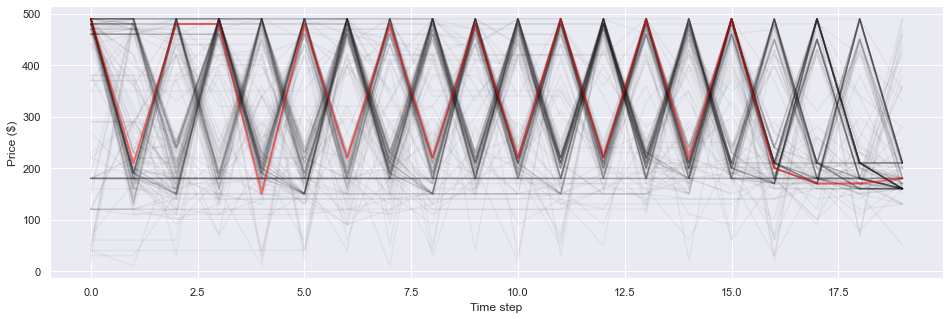

In [15]:
fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

The process starts with a random policy, but the network quickly learns the sawtooth pricing pattern. The following plot shows how returns change during the training process (the line is smoothed using a moving average filter with a window of size 10; the shaded area corresponds to two standard deviations over the window):

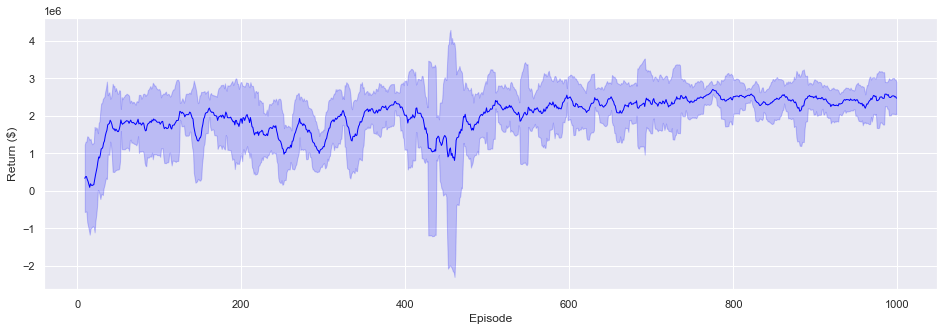

In [16]:
plot_return_trace(return_trace)

In [17]:
for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
    print(f'Best profit results: {profit}')

Best profit results: 2729963.9833596447
Best profit results: 2730975.6259576045
Best profit results: 2733640.828610392
Best profit results: 2734181.6251787236
Best profit results: 2734227.622152882
Best profit results: 2735253.9651555796
Best profit results: 2740713.961562144
Best profit results: 2755360.1623914475
Best profit results: 2756561.1655795733
Best profit results: 2778149.799953644


In [18]:
p_trace[-1]

[490,
 190,
 490,
 220,
 490,
 220,
 490,
 250,
 490,
 420,
 490,
 220,
 490,
 220,
 490,
 200,
 490,
 200,
 350,
 200]

## Implementation of DQN using RLlib

In real industrial settings, it is preferable to use stable frameworks that provide reinforcement learning algorithms and other tools out of the box. Consequently, our next step is to reimplement the same optimizer using RLlib, a popular and widely-used open-source library for reinforcement learning.

We start with the development of a simple wrapper for our environment that casts it to the standard OpenAI Gym interface. We simply need to add a few minor details. First, the environment needs to fully encapsulate the state. Second, dimensionality and type of action and state (observation) spaces have to be explicitly specified:

In [25]:
import gym
from gym.spaces import Discrete, Box

class HiLoPricingEnv(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Discrete(len(price_grid))
        self.observation_space = Box(0, 10000, shape=(2*T, ), dtype=np.float32)

    def reset(self):
        self.state = env_intial_state()
        self.t = 0
        return self.state

    # Returns next state, reward, and end-of-the-episode flag  
    def step(self, action):
        next_state, reward = env_step(self.t, self.state, action)
        self.t += 1
        self.state = next_state
        return next_state, reward, self.t == T - 1, {}

In [33]:
import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print

ray.shutdown()
ray.init()

def train_dqn():
    config = dqn.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["framework"] = "torch"
    config["lr"] = 0.002
    config["gamma"] = 0.80
    config["train_batch_size"] = 512
    config["buffer_size"] = 10000
    config["timesteps_per_iteration"] = 5000
    config["hiddens"] = [128, 128, 128]
    trainer = dqn.DQNTrainer(config=config, env=HiLoPricingEnv)
    for i in range(2):
        result = trainer.train()
        print(pretty_print(result))

train_dqn()

2021-04-09 17:34:49,178	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-09 17:34:51,627	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-09 17:34:51,635	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-09 17:34:51,684	WARNING util.py:47 -- Install gputil for GPU system monitoring.


custom_metrics: {}
date: 2021-04-09_17-36-42
done: false
episode_len_mean: 19.0
episode_reward_max: 1721158.9042733158
episode_reward_mean: 301271.46224075416
episode_reward_min: -2161041.355337721
episodes_this_iter: 263
episodes_total: 263
experiment_id: 837d3c1254594485811e2e892a16b6dc
hostname: Zhi-Yuan-Lim
info:
  last_target_update_ts: 4528
  learner:
    default_policy:
      allreduce_latency: 0.0
      cur_lr: 0.002
      grad_gnorm: 2535.254150390625
      max_q: 667817.125
      mean_q: 383616.1875
      mean_td_error: 26778.919921875
      min_q: -399758.40625
  num_steps_sampled: 5000
  num_steps_trained: 512512
  num_target_updates: 8
iterations_since_restore: 1
node_ip: 192.168.1.61
num_healthy_workers: 0
off_policy_estimator: {}
perf:
  cpu_util_percent: 28.627388535031848
  ram_util_percent: 62.045859872611445
pid: 63295
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_action_processing_ms: 0.058688060971790024
  mean_env_wait_ms: